[View in Colaboratory](https://colab.research.google.com/github/brynmwangy/predicting-bitcoin-prices-using-LSTM/blob/master/btc.ipynb)

In [43]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline


In [45]:
#we now define the network
#Hyperparameters used in the network
batch_size = 10 #how many windows of data we are passing at once
window_size_en = 30 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 # How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 40
training_test_blocks=5

In [46]:
#decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)
# eu = pd.read_csv('./data/us_euro_daily_exrate.csv')
eu = pd.read_csv('./data/us_euro_daily_exrate.csv', parse_dates=[0])

In [47]:
# eu['Value']=eu['Value'].fillna(eu['Value'].mean())

In [48]:
# eu[eu['Value'].isnull()].fillna(eu['Value'].mean())


# df['nr_item_ave']=df['nr_items].fillna(mean_value)
# eu.apply(lambda x: x.fillna(x.mean()),axis=0)
# df.apply(lambda x: x.fillna(x.mean()),axis=0)


In [49]:
#selecting only the column that we are going to use in the prediction process

#data_to_use=btc['Value'].values
# data_df = eu[~eu['Value'].isnull()]
# eu_rates = data_df['Value'].astype(float)
eu_rates = eu['Value'].astype(float)
data_to_use=eu_rates.values
data_to_use
len(data_to_use)

4934

In [50]:
# eu_weekly = data_df.groupby([data_df.index, data_df['Date'].dt.strftime('%W'), data_df['Date'].dt.strftime('%Y')])['Value'].mean()
eu_time_line = pd.DataFrame(eu.groupby([eu.index, eu['Date'].dt.strftime('%W')])['Value'].mean())

In [51]:
eu_time_line = eu_time_line.reset_index('Date')

In [52]:
# n = pd.DataFrame(eu_weekly).reset_index('Date')
eu_time_line['Year']= eu['Date'].dt.strftime('%Y')

In [53]:
eu_time_line = eu_time_line.rename(columns={'Date':'Week'})

In [54]:
eu_time_line['Month']= eu['Date'].dt.strftime('%m')
eu_time_line = eu_time_line.rename(columns={'Date':'Month'})

In [55]:
eu_time_line.head()

,Week,Value,Year,Month
0,01,0.8466,1999,01
1,01,0.8503,1999,01
2,01,0.8594,1999,01
3,01,0.8568,1999,01
4,01,0.8655,1999,01


In [56]:
#days_count = eu_time_line.groupby(['Year', 'Week']).count() 

In [57]:
eu_weekly_arr = (eu_time_line.groupby(['Year', 'Week']).mean()).values

In [58]:
eu_weekly_arr.shape

(997, 1)

In [59]:
eu_weekly_arr_to_use = np.repeat(eu_weekly_arr,5)

In [60]:
len(eu_weekly_arr_to_use)

4985

In [61]:
eu_weekly_arr_to_use.shape

(4985,)

In [62]:
print(len(eu_weekly_arr_to_use))

4985


In [63]:
eu_monthly_arr = (eu_time_line.groupby(['Year', 'Month']).mean()).values

In [64]:
eu_monthly_arr.shape

(228, 1)

In [65]:
eu_monthly_arr_to_use = np.repeat(eu_monthly_arr,22)

In [66]:
eu_yearly_arr = (eu_time_line.groupby(['Year']).mean()).values

In [67]:
eu_yearly_arr_to_use = np.repeat(eu_yearly_arr, 260)

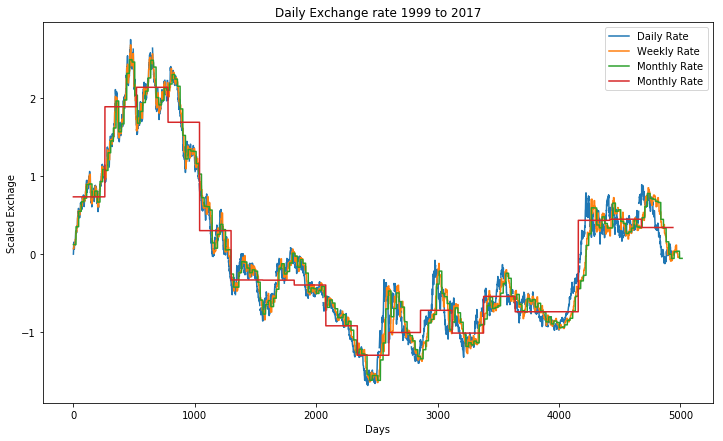

In [68]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
scaled_weekly_data = scaler.fit_transform(eu_weekly_arr_to_use.reshape(-1, 1))
scaled_monthly_data = scaler.fit_transform(eu_monthly_arr_to_use.reshape(-1, 1))
scaled_yearly_data = scaler.fit_transform(eu_yearly_arr_to_use.reshape(-1, 1))


#plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Daily Exchange rate 1999 to 2017')
plt.xlabel('Days')
plt.ylabel('Scaled Exchage')
plt.plot(scaled_data, label='Daily Rate')
plt.plot(scaled_weekly_data, label='Weekly Rate')
plt.plot(scaled_monthly_data, label = 'Monthly Rate')
plt.plot(scaled_yearly_data, label = 'Monthly Rate')
plt.legend()
plt.show()

In [69]:
data_df = eu[~eu['Value'].isnull()]
eu_rates = data_df['Value'].astype(float)
# eu_rates = eu['Value'].astype(float)
data_to_use=eu_rates.values
data_to_use
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
len(data_to_use)


4754

In [70]:
# eu['Value']=eu['Value'].fillna(eu['Value'].mean())
# eu_rates = eu['Value'].astype(float)
# data_to_use=eu_rates.values
# data_to_use

In [71]:
# eu[eu['Value'].isnull()]

In [72]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, window_size_en)


#we now split the data into training and test set
import numpy as np
test_portion = len(X) // training_test_blocks
train_i = len(X) - test_portion

# X_train  = np.array(X[:1018])
# y_train = np.array(y[:1018])

# X_test = np.array(X[1018:])
# y_test = np.array(y[1018:])

X_train  = np.array(X[:train_i])
y_train = np.array(y[:train_i])

X_test = np.array(X[train_i:])
y_test = np.array(y[train_i:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (3780, 30, 1)
y_train size: (3780, 1)
X_test size: (944, 30, 1)
y_test size: (944, 1)


In [73]:
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size_en, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])



#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 #we now define loop for the network
outputs = []
accuracies = []
for i in range(batch_size): #Iterates through every window in the batch
  
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size_en):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    prediction = tf.matmul(batch_output, weights_output) + bias_output_layer
    outputs.append(prediction)
    
#################################################    
# MINST
#    prediction=tf.matmul(outputs[-1],out_weights)+out_bias
    correct_prediction=tf.equal(tf.argmax(prediction,1),tf.argmax(targets ,1))
    accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    accuracies.append(accuracy)
#################################################    
outputs 

[<tf.Tensor 'add_2980:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3251:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3522:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3793:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4064:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4335:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4606:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4877:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5148:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5419:0' shape=(1, 1) dtype=float32>]

In [74]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    traind_acc = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
#        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        o, c, a, _ = session.run([outputs, loss, accuracies, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        traind_acc.append(a)
        
        ii += batch_size
    if ((i % 10) == 0 or (i==(epochs-1))):
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
#        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)), 'Average Accuracy : {}'.format(np.mean(a)))
        

Epoch 0/40  Current loss: 0.08724839985370636
Epoch 10/40  Current loss: 0.07462633401155472
Epoch 20/40  Current loss: 0.03947233408689499
Epoch 30/40  Current loss: 0.00986451655626297
Epoch 39/40  Current loss: 0.004488627891987562


In [75]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [76]:
X_test.shape, len(traind_scores)

((944, 30, 1), 378)

In [77]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [78]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])        

In [79]:
len(tests_new), len(X)

(940, 4724)

In [80]:
#for i, e in enumerate(tests_new): print(i, " -> ",e)

In [81]:
train_i, len(tests_new)

(3780, 940)

In [82]:
test_results = []
for e in range(train_i) : test_results.append(None)

# rest from train_i to the end of list
for i in range(len(tests_new)):
#    print("i-> :",i)
    test_results.append(tests_new[i] )


In [83]:
# test_results = []
# g_i = train_i + 1
# for i in range(len(X)):
#     if i >= g_i:
#         print("i i-gi -> ",i,":" , i-g_i, ":",tests_new[i-g_i])
#         test_results.append(tests_new[i-g_i])
#     else:
#         test_results.append(None)


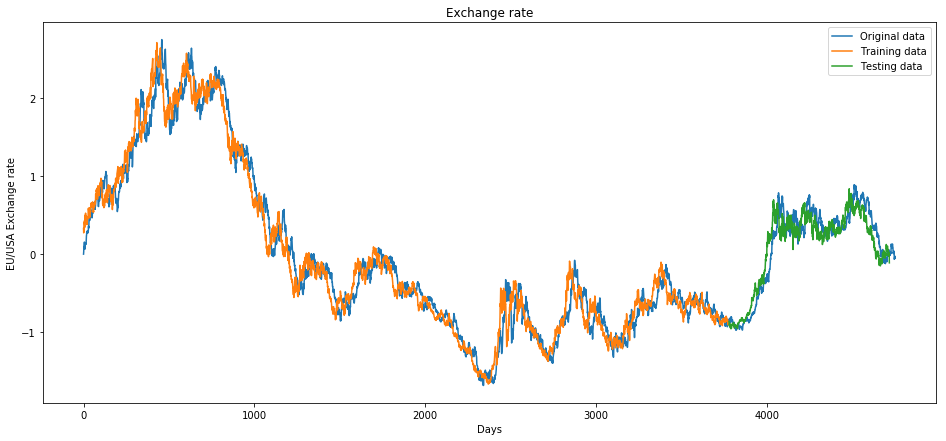

In [84]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Exchange rate')
plt.xlabel('Days')
plt.ylabel('EU/USA Exchange rate')
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()


In [85]:
y[len(y)-10:]

[array([0.00961467]),
 array([0.04149509]),
 array([0.04149509]),
 array([0.01492808]),
 array([-0.06401389]),
 array([-0.05035086]),
 array([-0.03289254]),
 array([-0.02226574]),
 array([-0.04351934]),
 array([-0.05035086])]

In [86]:
y_new_inverse = scaler.inverse_transform(y[len(y)-1])

In [87]:
y_new_inverse

array([0.8396])

In [88]:
tests_new[len(tests_new)-1][0]

array([-0.10914999], dtype=float32)

In [89]:
test_new_inverse = scaler.inverse_transform(tests_new[len(tests_new)-1])

In [90]:
test_new_inverse

array([[0.8318537]], dtype=float32)